In [30]:
import networkx as nx
import pandas as pd
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict 
from dgl.nn import SAGEConv
import scipy.sparse as sp
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import dgl
from dgl.data.utils import save_graphs
from dgl import load_graphs

In [3]:
from dgl.nn import SAGEConv
import dgl.data

In [4]:
#%autosave 0

Autosave disabled


# EDA

In [13]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
categorical = ['key', 'mode', 'time_signature']

In [27]:
with open("" + 'mpd.slice.{}-{}.json'.format(0, 999)) as f:
        data = json.load(f)
        playlists = data['playlists']

In [ ]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

In [73]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [74]:
%%time
feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for each in np.random.choice(999, 200):
    item = playlists[each]
    row_ids = []
    for i in item['tracks']:
        row = edafeats[edafeats['uri'] == i['track_uri']].index.item()
        row_ids.append(row)

    cur_feats = edafeats.iloc[row_ids]

    for i in numerical:
        var = np.var(cur_feats[i])
        feat_vars[i].append(var)
        
        avg = np.mean(cur_feats[i])
        feat_avgs[i].append(avg)
    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i].append(highest)

CPU times: user 2min 39s, sys: 322 ms, total: 2min 40s
Wall time: 2min 40s


In [75]:
feat_avgs.pop('key')
feat_avgs.pop('mode')
feat_avgs.pop('time_signature')

[]

In [76]:
for i in list(feat_vars.keys()):
    print(i, np.mean(feat_vars[i]))

danceability 0.017336247228631585
energy 0.027802018795663744
loudness 0.35974512463583996
speechiness 0.006335275255969176
acousticness 0.04961921645380942
instrumentalness 0.020206595814568802
liveness 0.019993579739552073
valence 0.04086572118192583
tempo 0.8958084474863978
duration_ms 0.3048734709345499
key 0.193673401827415
mode 0.7014418832578955
time_signature 0.9303994774551134


In [77]:
for i in list(feat_avgs.keys()):
    print(i, len(feat_avgs[i]))

danceability 200
energy 200
loudness 200
speechiness 200
acousticness 200
instrumentalness 200
liveness 200
valence 200
tempo 200
duration_ms 200


# Within Playlists EDA (From 200 Song Sample)

When plotting the distribution of variance for danceability of the 200 sampled playlists we can see that it follows a sort of bimodal distribution, where the variance is always quite low. This suggests that the songs within each playlist follow a sort of similarity in danceability. As we plot the variances of the other playlists we can get different values.

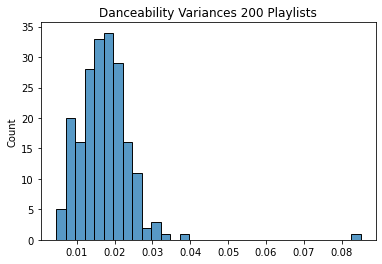

In [81]:
danceability_variances = sns.histplot(feat_vars['danceability']).set(title='Danceability Variances 200 Playlists')

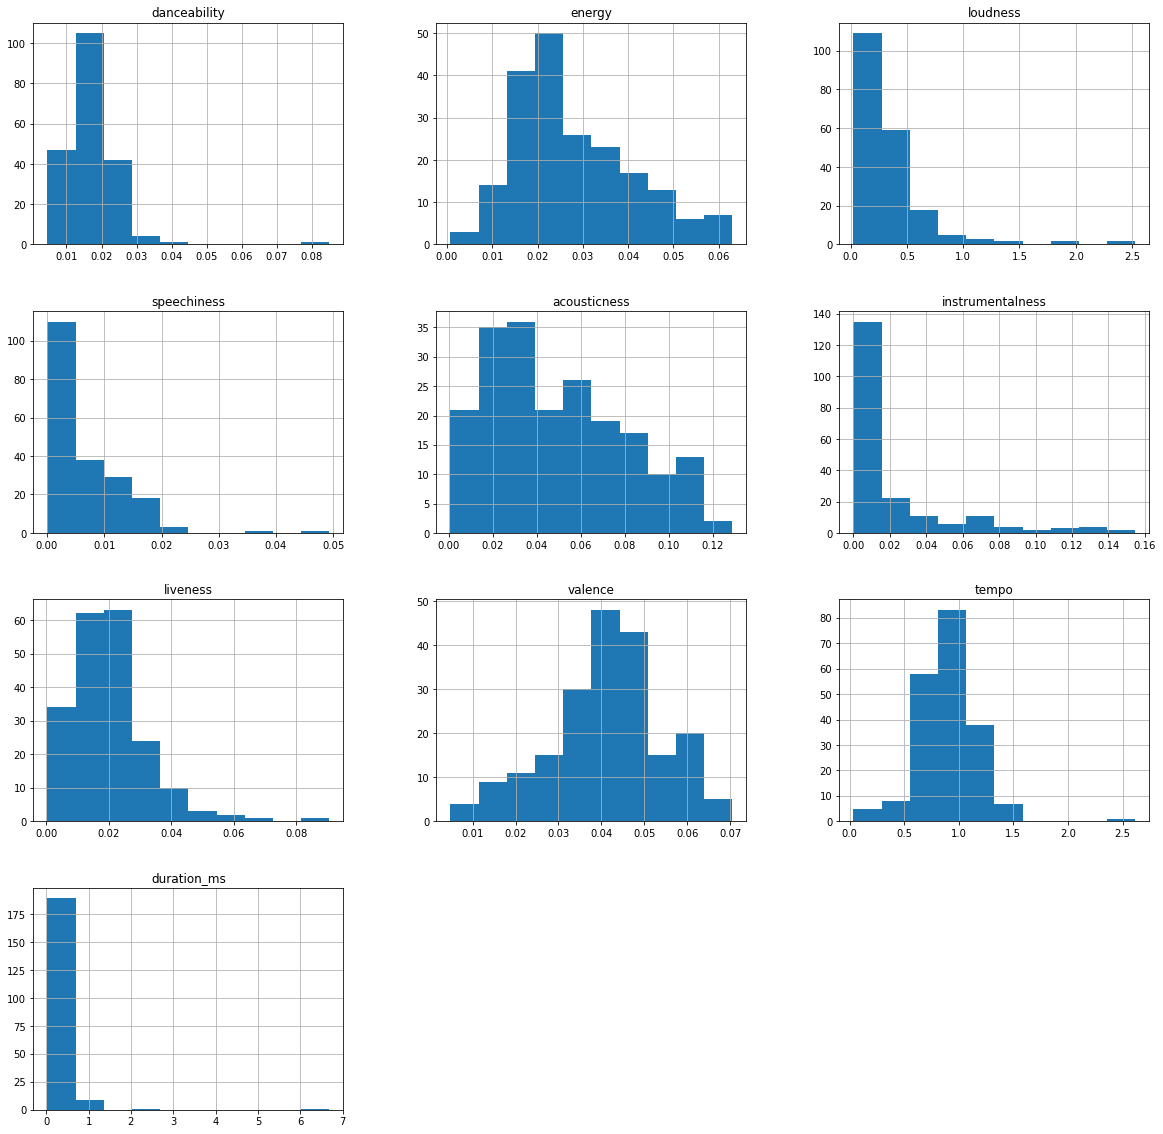

In [78]:
var_hists = pd.DataFrame(feat_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

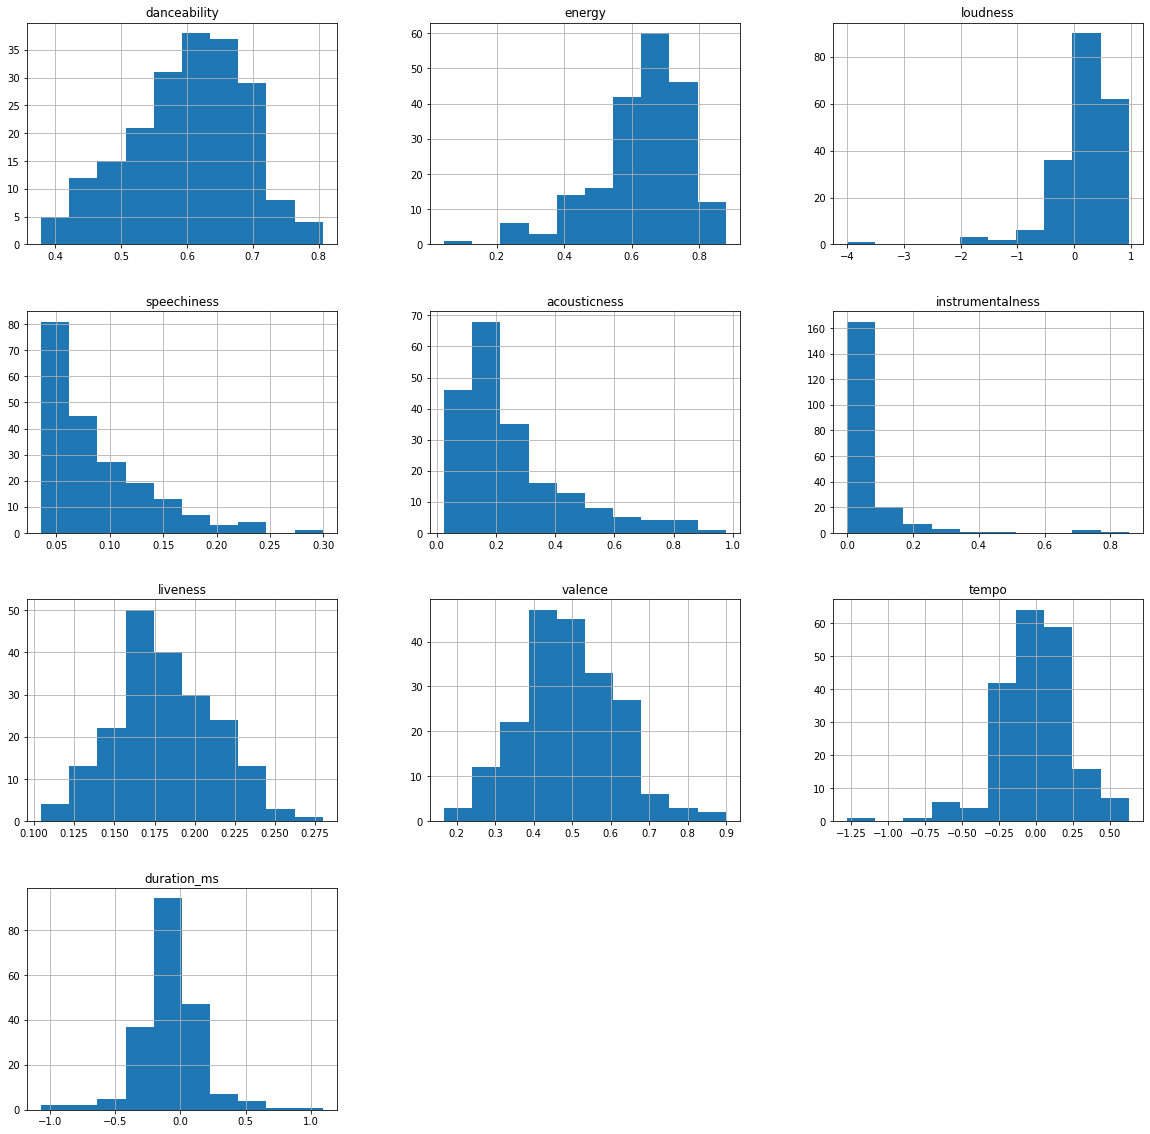

In [79]:
avg_hists = pd.DataFrame(feat_avgs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

# Overall Songs EDA

<AxesSubplot:ylabel='time_signature'>

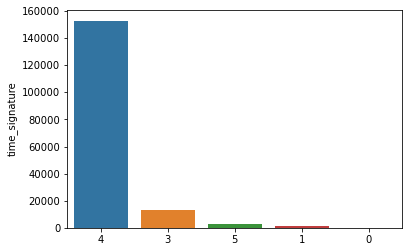

In [46]:
sns.barplot(y=edafeats['time_signature'].value_counts(), x=[str(i) for i in edafeats['time_signature'].value_counts().index])

<AxesSubplot:ylabel='key'>

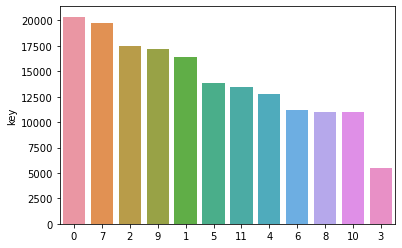

In [45]:
sns.barplot(y=edafeats['key'].value_counts(), x=[str(i) for i in edafeats['key'].value_counts().index])

<AxesSubplot:ylabel='mode'>

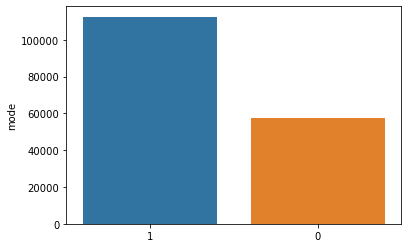

In [76]:
sns.barplot(y=edafeats['mode'].value_counts(), x=[str(i) for i in edafeats['mode'].value_counts().index])

<AxesSubplot:xlabel='energy', ylabel='Count'>

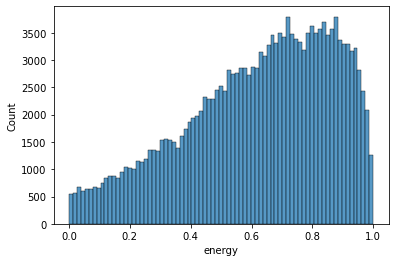

In [29]:
sns.histplot(edafeats['energy'])

<AxesSubplot:xlabel='danceability', ylabel='Count'>

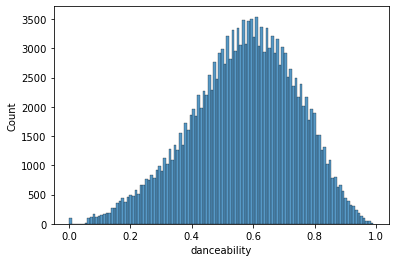

In [73]:
sns.histplot(edafeats['danceability'])

<AxesSubplot:xlabel='loudness', ylabel='Count'>

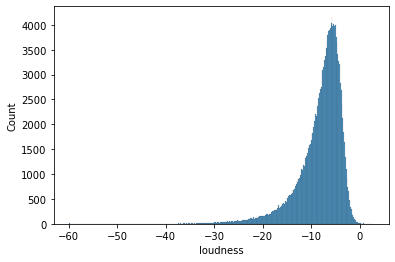

In [75]:
sns.histplot(edafeats['loudness'])

<AxesSubplot:xlabel='speechiness', ylabel='Count'>

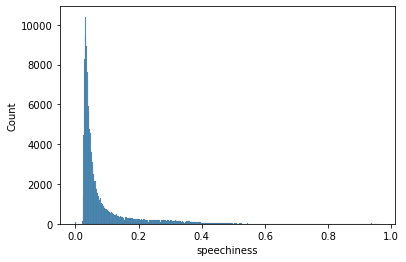

In [77]:
sns.histplot(edafeats['speechiness'])

<AxesSubplot:xlabel='acousticness', ylabel='Count'>

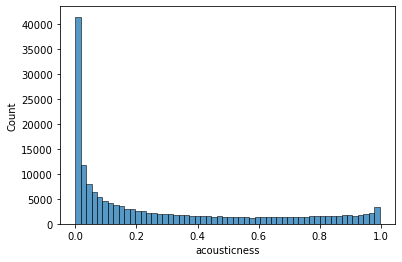

In [78]:
sns.histplot(edafeats['acousticness'])

<AxesSubplot:xlabel='instrumentalness', ylabel='Count'>

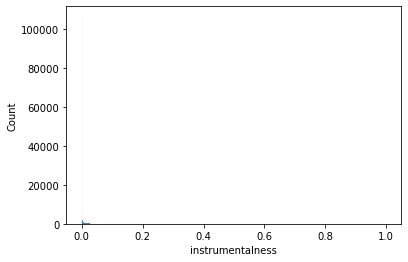

In [80]:
sns.histplot(features['instrumentalness'])

<AxesSubplot:xlabel='liveness', ylabel='Count'>

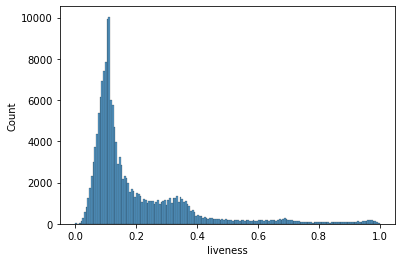

In [82]:
sns.histplot(edafeats['liveness'])

<AxesSubplot:xlabel='valence', ylabel='Count'>

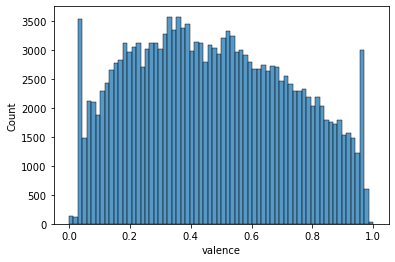

In [84]:
sns.histplot(edafeats['valence'])

<AxesSubplot:xlabel='tempo', ylabel='Count'>

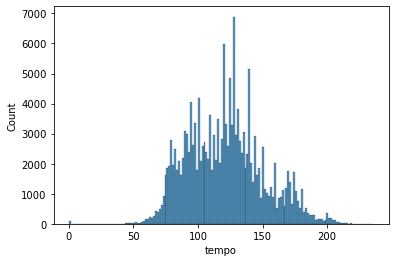

In [83]:
sns.histplot(edafeats['tempo'])

<AxesSubplot:xlabel='duration_ms', ylabel='Count'>

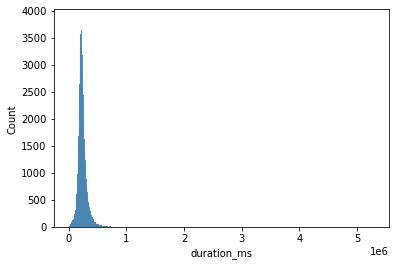

In [85]:
sns.histplot(edafeats['duration_ms'])